In [1]:
# Cell 1: Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Cell 2: Kernel function and Silverman bandwidth

def _kernel_weights(u, kernel="epa"):
    """
    Kernel weights K(u). We DO NOT include the 1/h factor here.
    That factor is applied outside when needed (as in lprobust).
    """
    u = np.asarray(u, float)
    k = kernel.lower()

    if k in ("epa", "epanechnikov"):
        w = 0.75 * (1.0 - u**2)
        w[np.abs(u) > 1] = 0.0
        return w
    elif k in ("tri", "triangular"):
        w = 1.0 - np.abs(u)
        w[np.abs(u) > 1] = 0.0
        return w
    elif k in ("uni", "uniform"):
        return (np.abs(u) <= 1).astype(float)
    elif k in ("gau", "gaussian"):
        return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
    else:
        raise ValueError(f"Unknown kernel '{kernel}'")


def _silverman_bandwidth(x):
    """
    Silverman's rule of thumb: h ≈ 1.06 * sd * n^(-1/5).
    Only used as a default if no bandwidth is given explicitly.
    """
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    n = x.size
    if n < 2:
        raise ValueError("Not enough data to compute bandwidth")
    std = x.std(ddof=1)
    if std == 0:
        return 1e-8
    return 1.06 * std * n ** (-1 / 5)


In [3]:
# Cell 3: Clone of lprobust.res for vce="nn"

def _nn_residuals_lprobust_style(x_sorted, y_sorted, matches=3):
    """
    Very close translation of lprobust.res for vce = "nn".
    Assumes x_sorted is sorted in increasing order.
    """
    x_sorted = np.asarray(x_sorted, float)
    y_sorted = np.asarray(y_sorted, float)
    n = len(y_sorted)
    if n <= 1:
        return np.zeros_like(y_sorted)

    # We emulate 1-based indexing as in R
    xR = np.empty(n + 1, float)
    yR = np.empty(n + 1, float)
    xR[0] = np.nan
    yR[0] = np.nan
    xR[1:] = x_sorted
    yR[1:] = y_sorted

    dupsR = np.zeros(n + 1, dtype=int)
    dupsidR = np.zeros(n + 1, dtype=int)

    # dups[j] = how many times x[j] appears among all x's
    for jR in range(1, n + 1):
        dupsR[jR] = np.sum(xR[1:] == xR[jR])

    # dupsid: 1,...,k inside each block of duplicates
    jR = 1
    while jR <= n:
        k = dupsR[jR]
        if k <= 0:
            k = 1
        dupsidR[jR:jR + k] = np.arange(1, k + 1, dtype=int)
        jR += k

    resR = np.zeros(n + 1, float)
    max_m = min(matches, n - 1)

    for posR in range(1, n + 1):
        rpos = int(dupsR[posR] - dupsidR[posR])
        lpos = int(dupsidR[posR] - 1)

        while lpos + rpos < max_m:
            if posR - lpos - 1 <= 0:
                idxR = posR + rpos + 1
                if idxR > n:
                    break
                rpos += int(dupsR[idxR])
            elif posR + rpos + 1 > n:
                idxL = posR - lpos - 1
                if idxL < 1:
                    break
                lpos += int(dupsR[idxL])
            elif (xR[posR] - xR[posR - lpos - 1]) > (xR[posR + rpos + 1] - xR[posR]):
                rpos += int(dupsR[posR + rpos + 1])
            elif (xR[posR] - xR[posR - lpos - 1]) < (xR[posR + rpos + 1] - xR[posR]):
                lpos += int(dupsR[posR - lpos - 1])
            else:
                rpos += int(dupsR[posR + rpos + 1])
                lpos += int(dupsR[posR - lpos - 1])

        indJ_start = posR - lpos
        indJ_end = min(n, posR + rpos)
        idxs = np.arange(indJ_start, indJ_end + 1, dtype=int)
        Ji = idxs.size - 1

        if Ji <= 0:
            resR[posR] = 0.0
            continue

        yJ = np.sum(yR[idxs]) - yR[posR]
        resR[posR] = np.sqrt(Ji / (Ji + 1.0)) * (yR[posR] - yJ / Ji)

    # Back to 0-based indexing
    return resR[1:]


In [4]:
# Cell 4: RBC version of lprobust (p=1, q=2, deriv=0, eval=0)

def _lprobust_rbc_mu_se(x, y, h, kernel="tri", matches=3, b=None):
    """
    Very close to lprobust with:
      p = 1, q = 2, deriv = 0, eval = 0, vce = "nn"

    Returns:
      tau_cl  : conventional local linear intercept (tau.us)
      tau_bc  : bias-corrected intercept (tau.bc)
      se_rb   : robust bias-corrected standard error (se.rb)
      n_in_bw : effective number of observations in the bandwidth
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]

    if x.size == 0:
        raise ValueError("No data")

    # Sort as in vce = "nn"
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    if b is None:
        b = h  # same as rho = 1 default in lprobust

    # Weights W.fun((x - eval)/h) / h with eval = 0
    u_h = x / h
    u_b = x / b
    W_h = _kernel_weights(u_h, kernel=kernel) / h
    W_b = _kernel_weights(u_b, kernel=kernel) / b

    ind_h = W_h > 0
    ind_b = W_b > 0
    ind = ind_b.copy()
    if h > b:
        ind = ind_h

    eX = x[ind]
    eY = y[ind]
    Wh = W_h[ind]
    Wb = W_b[ind]

    n = eX.size
    if n == 0:
        raise ValueError("No obs in kernel support.")

    # R.q = [1, x, x^2], R.p = [1, x]
    R_q = np.vstack([np.ones(n), eX, eX**2]).T
    R_p = R_q[:, :2]

    # u = (x - eval) / h = x/h
    u = eX / h

    # L = crossprod(R.p * W.h, u^(p+1)), with p = 1 => u^2
    L = (R_p * Wh[:, None]).T @ (u**2)
    L = L.reshape(2, 1)

    # invG.q = qrXXinv((sqrt(W.b) * R.q))
    Xq = np.sqrt(Wb)[:, None] * R_q
    Gq = Xq.T @ Xq
    invG_q = np.linalg.inv(Gq)

    # invG.p = qrXXinv((sqrt(W.h) * R.p))
    Xp = np.sqrt(Wh)[:, None] * R_p
    Gp = Xp.T @ Xp
    invG_p = np.linalg.inv(Gp)

    # e.p1 has 1 in position (p+2) = 3 ⇒ index 2 in 0-based
    e_p1 = np.array([[0.0], [0.0], [1.0]])  # (3 x 1)

    # A = L %*% t(e.p1)  => 2 x 3
    A = L @ e_p1.T

    # t(t(invG.q %*% t(R.q)) * W.b)
    M = invG_q @ R_q.T        # 3 x n
    C = (M.T * Wb[:, None]).T # 3 x n

    # Term = h^(p+1) * (A %*% C), p=1 => h^2
    Term = (h**2) * (A @ C)   # 2 x n

    # t(R.p * W.h)
    Term1 = (R_p * Wh[:, None]).T  # 2 x n

    # Q.q = t(Term1 - Term) => n x 2
    Q_q = (Term1 - Term).T

    # Conventional beta.p and tau_cl
    beta_p = invG_p @ ((R_p * Wh[:, None]).T @ eY)
    tau_cl = beta_p[0]

    # Bias-corrected beta.bc and tau_bc
    beta_bc = invG_p @ (Q_q.T @ eY)
    tau_bc = beta_bc[0]

    # NN residuals (as in lprobust.res with vce = "nn")
    res_nn = _nn_residuals_lprobust_style(eX, eY, matches=matches)

    # lprobust.vce(Q.q, res, C=NULL) = crossprod(c(res) * Q.q)
    RX = Q_q
    B = res_nn[:, None] * RX
    M_bc = B.T @ B  # 2 x 2

    # V_beta_bc = invG.p %*% M_bc %*% invG.p
    V_beta_bc = invG_p @ M_bc @ invG_p
    se_rb = np.sqrt(max(V_beta_bc[0, 0], 0.0))

    return float(tau_cl), float(tau_bc), float(se_rb), int(n)


In [5]:
# Cell 5: QUG (Quasi-Untreated Group) test

def _qg_test(dose_array):
    """
    Quasi-untreated group test (same logic as in the paper):

    Let D1 and D2 be the two smallest strictly positive doses.
    Then:

        T = D1 / (D2 - D1)
        p = 1 / (1 + T)

    Returns (T, p_value).
    """
    x = np.asarray(dose_array, float)
    pos = x[x > 0]
    pos = np.sort(pos)
    if pos.size < 2:
        return np.nan, np.nan
    d1, d2 = pos[0], pos[1]
    if d2 <= d1:
        return np.nan, np.nan
    T = d1 / (d2 - d1)
    if T <= 0:
        return T, np.nan
    p_val = 1.0 / (1.0 + T)
    return T, p_val


In [6]:
# Cell 6: HAD estimator (did_had) in Python

def did_had_python(
    df,
    outcome,
    group,
    time,
    treatment,
    effects=1,
    placebo=0,
    dynamic=False,
    kernel="epa",
    bandwidth=None,
    bandwidth_effect=None,
    bandwidth_placebo=None,
    alpha=0.05,
    nnmatch=3,
):
    """
    Heterogeneous Adoption Design (HAD) estimator in Python.

    This mirrors the logic of Stata's did_had / did_had_est:
      - Uses lprobust (p=1,q=2,deriv=0,eval=0,vce=nn) to obtain
        tau.us (tau_cl), tau.bc, and se.rb.
      - Computes ß_qs, bias term, and CIs as in did_had_est.
    """

    df = df.copy()
    cols = [group, time, outcome, treatment]
    df = df[cols].dropna()

    # Ensure numeric types
    for c in cols:
        df[c] = pd.to_numeric(df[c])

    # Wide panel: rows = groups, columns = time periods
    y_pivot = df.pivot(index=group, columns=time, values=outcome)
    d_pivot = df.pivot(index=group, columns=time, values=treatment)
    groups = y_pivot.index.to_numpy()
    times = np.sort(y_pivot.columns.to_numpy())

    # First period with positive treatment (F)
    F = None
    for t_val in times:
        if (d_pivot[t_val] > 0).any():
            F = t_val
            break
    if F is None:
        raise ValueError("Could not find adoption period F (no positive treatment).")

    Fm1 = F - 1
    t_min = times.min()
    t_max = times.max()

    # Check: treatment must be zero before F
    for t_val in times[times < F]:
        if (d_pivot[t_val] != 0).any():
            raise ValueError(f"Treatment is nonzero before F at t={t_val}.")

    # Max feasible effect horizon
    max_effect = int(effects)
    while max_effect > 0 and (Fm1 + max_effect > t_max):
        max_effect -= 1

    # Max feasible placebo horizon
    max_placebo = int(placebo)
    while max_placebo > 0 and (Fm1 - max_placebo < t_min):
        max_placebo -= 1

    if max_effect == 0 and max_placebo == 0:
        raise ValueError("No feasible effect or placebo horizons given the time range.")

    # Helper: bandwidth by horizon for effects
    def _get_bw_effect(ell):
        if bandwidth_effect is None:
            return bandwidth
        if np.isscalar(bandwidth_effect):
            return float(bandwidth_effect)
        if isinstance(bandwidth_effect, dict):
            return float(bandwidth_effect.get(ell, bandwidth))
        raise ValueError("bandwidth_effect must be None, scalar, or dict")

    # Helper: bandwidth by horizon for placebos
    def _get_bw_placebo(ell):
        if bandwidth_placebo is None:
            return bandwidth
        if np.isscalar(bandwidth_placebo):
            return float(bandwidth_placebo)
        if isinstance(bandwidth_placebo, dict):
            return float(bandwidth_placebo.get(ell, bandwidth))
        raise ValueError("bandwidth_placebo must be None, scalar, or dict")

    # Normal critical value
    z_crit = 1.959963984540054  # ≈ N(0,1) quantile at 0.975

    def _compute_effect_for_arrays(delta_y, dose_use, dose_norm, kernel, bw_override):
        """
        Core HAD step:

        Given:
          - delta_y: outcome differences
          - dose_use: dose used in kernel
          - dose_norm: dose used for normalization

        It computes:
          - ß_qs (Estimate) using tau.us
          - se (RBC) using se.rb
          - CI with bias correction as in did_had_est.
        """
        delta_y = np.asarray(delta_y, float)
        dose_use = np.asarray(dose_use, float)
        dose_norm = np.asarray(dose_norm, float)

        mask = ~(np.isnan(delta_y) | np.isnan(dose_use) | np.isnan(dose_norm))
        delta_y = delta_y[mask]
        dose_use = dose_use[mask]
        dose_norm = dose_norm[mask]

        if delta_y.size == 0:
            raise ValueError("No valid observations at this horizon.")

        delta_mean = delta_y.mean()
        dose_norm_mean = dose_norm.mean()
        if dose_norm_mean == 0:
            raise ValueError("Average normalization dose is zero; cannot scale effect.")

        # Bandwidth: use the Stata one if provided, otherwise Silverman
        if bw_override is None:
            bw_eff = _silverman_bandwidth(dose_use)
        else:
            bw_eff = float(bw_override)

        # lprobust RBC: tau.us, tau.bc, se.rb
        tau_cl, tau_bc, se_mu, n_in_bw = _lprobust_rbc_mu_se(
            x=dose_use,
            y=delta_y,
            h=bw_eff,
            kernel=kernel,
            matches=nnmatch,
            b=None,
        )

        # ß_qs = (mean(Δy) - tau.us) / mean(d_norm)
        est_qs = (delta_mean - tau_cl) / dose_norm_mean

        # M_hat_hG = tau.us - tau.bc
        M_hat_hG = tau_cl - tau_bc

        # B_hat_Hg = - M_hat_hG / mean(d_norm)
        B_hat_Hg = - M_hat_hG / dose_norm_mean

        # se_est = se_mu / mean(d_norm)
        se_est = se_mu / dose_norm_mean

        # CI as in did_had_est:
        # low = ß_qs - B_hat_Hg - z * se_est
        # up  = ß_qs - B_hat_Hg + z * se_est
        low = est_qs - B_hat_Hg - z_crit * se_est
        up  = est_qs - B_hat_Hg + z_crit * se_est

        return est_qs, se_est, low, up, bw_eff, n_in_bw, delta_y, dose_use, dose_norm

    results_rows = []

    # --------------------------
    # Post-treatment effects
    # --------------------------
    for ell in range(1, max_effect + 1):
        t_post = Fm1 + ell
        if t_post not in y_pivot.columns:
            continue

        y_post = y_pivot[t_post]
        y_base = y_pivot[Fm1]
        delta_y = (y_post - y_base).to_numpy()

        dose_current = d_pivot[t_post].to_numpy()

        if dynamic:
            dose_norm = (
                d_pivot.loc[:, (times >= F) & (times <= t_post)]
                .sum(axis=1)
                .to_numpy()
            )
        else:
            dose_norm = dose_current.copy()

        bw_use = _get_bw_effect(ell)

        est, se_est, low, up, bw_eff, n_in_bw, dy_arr, du_arr, dn_arr = _compute_effect_for_arrays(
            delta_y,
            dose_current,
            dose_norm,
            kernel,
            bw_use,
        )

        T_qg, p_qg = _qg_test(du_arr)

        results_rows.append(
            {
                "type": "effect",
                "horizon": ell,
                "estimate": est,
                "se": se_est,
                "ci_lower": low,
                "ci_upper": up,
                "bandwidth": bw_eff,
                "n_in_bw": n_in_bw,
                "n_groups": dy_arr.size,
                "qg_T": T_qg,
                "qg_pval": p_qg,
            }
        )

    # --------------------------
    # Pre-treatment placebos
    # --------------------------
    for ell in range(1, max_placebo + 1):
        t_pre = Fm1 - ell
        t_future = Fm1 + ell
        if t_pre not in y_pivot.columns or t_future not in y_pivot.columns:
            continue

        y_pre = y_pivot[t_pre]
        y_base = y_pivot[Fm1]
        delta_y_pre = (y_pre - y_base).to_numpy()

        dose_future = d_pivot[t_future].to_numpy()

        if dynamic:
            dose_norm = (
                d_pivot.loc[:, (times >= F) & (times <= t_future)]
                .sum(axis=1)
                .to_numpy()
            )
        else:
            dose_norm = dose_future.copy()

        bw_use = _get_bw_placebo(ell)

        est, se_est, low, up, bw_eff, n_in_bw, dy_arr, du_arr, dn_arr = _compute_effect_for_arrays(
            delta_y_pre,
            dose_future,
            dose_norm,
            kernel,
            bw_use,
        )

        results_rows.append(
            {
                "type": "placebo",
                "horizon": ell,
                "estimate": est,
                "se": se_est,
                "ci_lower": low,
                "ci_upper": up,
                "bandwidth": bw_eff,
                "n_in_bw": n_in_bw,
                "n_groups": dy_arr.size,
                "qg_T": np.nan,
                "qg_pval": np.nan,
            }
        )

    results = pd.DataFrame(results_rows)
    results["name"] = np.where(
        results["type"] == "effect",
        "Effect_" + results["horizon"].astype(int).astype(str),
        "Placebo_" + results["horizon"].astype(int).astype(str),
    )

    return results


In [7]:
# Cell 7: Stata-like printing of results

def print_like_stata(results):
    """
    Print results with a layout similar to Stata's did_had output.
    """

    res = results.copy()
    eff = res[res["type"] == "effect"].sort_values("horizon")
    plc = res[res["type"] == "placebo"].sort_values("horizon")

    # Header for effects
    print("---------------------------------------------------------------------------")
    print("                          Effect Estimates                      QUG* Test")
    print("         --------------------------------------------------- ---------------")
    print("          Estimate       SE     LB.CI     UB.CI     N      BW    N.BW        T    p.val")

    for _, row in eff.iterrows():
        name = str(row["name"])
        est = row["estimate"]
        se = row["se"]
        lb = row["ci_lower"]
        ub = row["ci_upper"]
        n = int(row["n_groups"])
        bw = row["bandwidth"]
        nbw = int(row["n_in_bw"])
        T_qg = row["qg_T"]
        p_qg = row["qg_pval"]

        n_str = f"{n:,}"

        if np.isfinite(T_qg):
            T_str = f"{T_qg:8.5f}"
            p_str = f"{p_qg:8.5f}"
            T_part = f"{T_str} {p_str}"
        else:
            T_part = " " * 17

        print(
            f"{name:<9}"
            f"{est:9.5f} "
            f"{se:8.5f} "
            f"{lb:9.5f} "
            f"{ub:9.5f} "
            f"{n_str:>5} "
            f"{bw:7.5f} "
            f"{nbw:6d} "
            f"{T_part}"
        )

    print("*Quasi-Untreated Group\n")

    # Header for placebos
    if len(plc) > 0:
        print("--------------------------------------------------------------")
        print("                           Placebo Estimates")
        print("          ----------------------------------------------------")
        print("           Estimate       SE     LB.CI     UB.CI     N      BW    N.BW")

        for _, row in plc.iterrows():
            name = str(row["name"])
            est = row["estimate"]
            se = row["se"]
            lb = row["ci_lower"]
            ub = row["ci_upper"]
            n = int(row["n_groups"])
            bw = row["bandwidth"]
            nbw = int(row["n_in_bw"])
            n_str = f"{n:,}"

            print(
                f"{name:<9}"
                f"{est:9.5f} "
                f"{se:8.5f} "
                f"{lb:9.5f} "
                f"{ub:9.5f} "
                f"{n_str:>5} "
                f"{bw:7.5f} "
                f"{nbw:6d}"
            )


In [8]:
# Cell 8: Example using the tutorial_data from did_had

# Load the tutorial dataset (same as in the official repo)
url = (
    "https://raw.githubusercontent.com/chaisemartinPackages/"
    "did_had/main/tutorial_data.dta"
)
df_tutorial = pd.read_stata(url)

# Bandwidths taken from the official DIDHAD output
bw_eff = {1: 0.36133, 2: 0.27104, 3: 0.31407, 4: 0.41630, 5: 0.34105}
bw_pl = {1: 0.37026, 2: 0.38635, 3: 0.25068, 4: 0.20648}

# Run the Python HAD estimator
res = did_had_python(
    df=df_tutorial,
    outcome="y",
    group="g",
    time="t",
    treatment="d",
    effects=5,
    placebo=4,
    dynamic=False,
    kernel="tri",
    bandwidth_effect=bw_eff,
    bandwidth_placebo=bw_pl,
    alpha=0.05,
    nnmatch=3,
)

# Print in Stata-like format
print_like_stata(res)


---------------------------------------------------------------------------
                          Effect Estimates                      QUG* Test
         --------------------------------------------------- ---------------
          Estimate       SE     LB.CI     UB.CI     N      BW    N.BW        T    p.val
Effect_1   4.28198  0.55814   2.71751   4.90538 1,000 0.36133    371  3.96182  0.20154
Effect_2   3.59260  0.66675   2.02563   4.63925 1,000 0.27104    282  3.96182  0.20154
Effect_3   4.25466  0.67544   2.71354   5.36123 1,000 0.31407    324  3.96182  0.20154
Effect_4   3.97161  0.68909   2.35019   5.05137 1,000 0.41630    429  3.96182  0.20154
Effect_5   4.20530  0.67993   2.62381   5.28907 1,000 0.34105    354  3.96182  0.20154
*Quasi-Untreated Group

--------------------------------------------------------------
                           Placebo Estimates
          ----------------------------------------------------
           Estimate       SE     LB.CI     UB.CI     N 

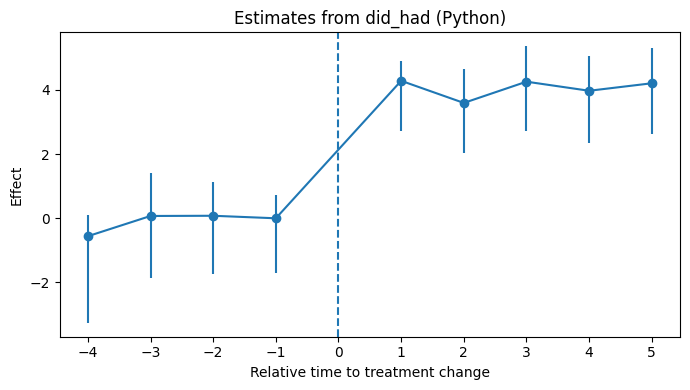

In [9]:
# Cell 9: Plot DIDHAD-style event-study graph

res_plot = res.copy()
res_plot["horizon_int"] = res_plot["name"].str.extract(r"_(\d+)").astype(int)
is_effect = res_plot["type"] == "effect"
res_plot["rel_time"] = np.where(is_effect, res_plot["horizon_int"], -res_plot["horizon_int"])
res_plot = res_plot.sort_values("rel_time")

x = res_plot["rel_time"].to_numpy()
y = res_plot["estimate"].to_numpy()
lo = res_plot["ci_lower"].to_numpy()
hi = res_plot["ci_upper"].to_numpy()

fig, ax = plt.subplots(figsize=(7, 4))

# Confidence intervals (like rcap in Stata)
for xi, yi_lo, yi_hi in zip(x, lo, hi):
    ax.vlines(xi, yi_lo, yi_hi)

ax.scatter(x, y)
ax.plot(x, y)
ax.axvline(0, linestyle="--")

ax.set_title("Estimates from did_had (Python)")
ax.set_xlabel("Relative time to treatment change")
ax.set_ylabel("Effect")
ax.set_xticks(range(int(x.min()), int(x.max()) + 1))

plt.tight_layout()
plt.show()
